In [1]:
import ML_Coupling.mo_descriptor as md
import ML_Coupling.nn_frame as nn
import numpy as np
import subprocess
import copy
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2023-03-02 17:43:09.460447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-02 17:43:09.460495: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [2]:
'''
1. load mo_pair descriptor
'''
homo_pairs = np.load('./data/homo_homo_pair.npy')
lumo_pairs = np.load('./data/lumo_lumo_pair.npy')
homo_rot_pairs = np.load('./data/homo_pair_rot.npy')
lumo_rot_pairs = np.load('./data/lumo_pair_rot.npy')

In [3]:
'''
2. read coupling
'''
raw_data = np.loadtxt('./data/results.csv', delimiter=',',comments='#')
raw_data_rot = np.loadtxt('./data/results_rot.csv', delimiter=',',comments='#')
c_homo = abs(raw_data[:,3])
c_lumo = abs(raw_data[:,4])
c_homo_rot = abs(raw_data_rot[:,3])
c_lumo_rot = abs(raw_data_rot[:,4])

In [4]:
'''
4. remove zero values for full data set
'''
ihzero = []
for ii,i in np.ndenumerate(c_homo):
    if i<=0.00000000:
        ihzero.append(ii)
        c_homo[ii] = 1e-9
print('Number of points to be deleted for homo:  ',len(ihzero))
homo_pairs  = np.delete(homo_pairs , ihzero, 0)
c_homo= np.delete(c_homo , ihzero, 0)

ilzero = []
for ii,i in np.ndenumerate(c_lumo):
    if i<=0.00000000:
        ilzero.append(ii)
        c_lumo[ii] = 1e-9
print('Number of points to be deleted for lumo:  ',len(ilzero))
lumo_pairs  = np.delete(lumo_pairs , ilzero, 0)
c_lumo = np.delete(c_lumo , ilzero, 0)

Number of points to be deleted for homo:   1154
Number of points to be deleted for lumo:   1140


In [5]:
'''
5. build training set
'''
n = 5
istart = n * 1681
iend = (n+1) * 1681
train_homo_pairs = homo_pairs[istart:iend]
train_lumo_pairs = lumo_pairs[istart:iend]

train_c_homo = -np.log(c_homo)[istart:iend]
train_c_lumo = -np.log(c_lumo)[istart:iend]

train_homo = copy.deepcopy(train_homo_pairs)
train_chomo = copy.deepcopy(train_c_homo)
print('Size of full training set for homo:   ',len(train_chomo))
index = np.random.choice(len(train_c_homo), size=int(len(train_c_homo)*0), replace=False)
train_homo_ = np.delete(train_homo,index,0)
train_chomo_ = np.delete(train_chomo,index,0)
print('Size of selected training set for homo:   ',len(train_homo_))

train_lumo = copy.deepcopy(train_lumo_pairs)
train_clumo = copy.deepcopy(train_c_lumo)
print('Size of full training set for lumo:   ',len(train_clumo))
index = np.random.choice(len(train_c_lumo), size=int(len(train_c_lumo)*0), replace=False)
train_lumo_ = np.delete(train_lumo,index,0)
train_clumo_ = np.delete(train_clumo,index,0)
print('Size of selected training set for lumo:   ',len(train_lumo_))

Size of full training set for homo:    1681
Size of selected training set for homo:    1681
Size of full training set for lumo:    1681
Size of selected training set for lumo:    1681


In [6]:
'''
6. build testing set
'''
iall = np.arange(len(train_c_homo))
idiff = np.setdiff1d(iall,index)
test_homo = np.delete(copy.deepcopy(train_homo_pairs),idiff,0)
test_chomo = np.delete(copy.deepcopy(train_chomo),idiff,0)

iall = np.arange(len(train_c_lumo))
idiff = np.setdiff1d(iall,index)
test_lumo = np.delete(copy.deepcopy(train_lumo_pairs),idiff,0)
test_clumo = np.delete(copy.deepcopy(train_clumo),idiff,0)

In [17]:
'''
7. load model 
''' 
imodel = 67767
setting = {'activation':'tanh','nn_shape':(256,256,256),'batch_size':len(train_homo_), 'training_steps':200000,\
'learning_rate': 0.00008, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./trained_model/nat_dimer_homo_total_%d'%len(train_homo_),\
'seed':None, 'debug_traj':False, 'pre_trained_path':'./trained_model/nat_dimer_homo_total_%d/model'%imodel}
NN_ho = nn.NN(setting_dict=setting)
pred_ho = np.exp(-NN_ho.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),)))


In [18]:
imodel2 = 9104
setting = {'activation':'tanh','nn_shape':(256,256,256),'batch_size':len(train_lumo_), 'training_steps':200000,\
'learning_rate': 0.00008, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./nat_dimer_lumo_total_%d'%len(train_lumo_),\
'seed':None, 'debug_traj':False, 'pre_trained_path':'./trained_model/nat_dimer_lumo_total_%d/model'%imodel2}
NN_lu = nn.NN(setting_dict=setting)
pred_lu = np.exp(-NN_lu.model(train_lumo_pairs, training=False).numpy().reshape((len(train_lumo_pairs),)))


In [19]:
error_ho = np.mean(np.multiply(abs(pred_ho-np.exp(-train_c_homo)), np.power(np.exp(-train_c_homo),-1))*100)
print(error_ho)
error_lu = np.mean(np.multiply(abs(pred_lu-train_c_lumo), np.power(train_c_lumo,-1))*100)


1.699314022464283


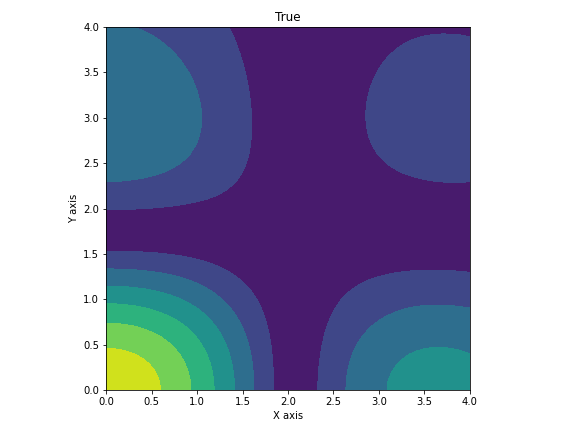

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
Z1 = np.exp(-train_c_homo).reshape((41,41))

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.contourf(x,y, Z1.T)
ax1.set_title('True')
ax1.set_aspect('equal')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
plt.tight_layout()
plt.savefig('2d_true.png')

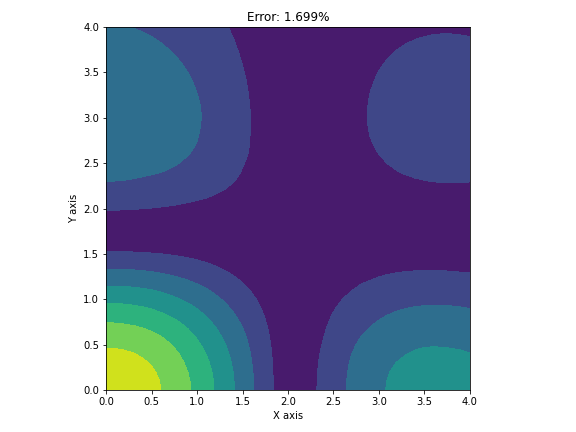

In [21]:
Z = pred_ho.reshape((41,41))

fig2, ax2 = plt.subplots(figsize=(8,6))
ax2.contourf(x,y, Z.T)
ax2.set_aspect('equal')
ax2.set_title('Error: %5.3f%%'%error_ho)
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
plt.tight_layout()
plt.savefig('2d_pred_model%d.png'%imodel, transparent=False)

In [1]:
import ML_Coupling.tools as tool

In [2]:
a= tool.cal_dexter_coupling('ML_Coupling/test.out')

In [5]:
print(a*27.2114)

0.13073721180792908
